In [39]:
import os
import pandas as pd
import numpy as np
from scipy import spatial
import seaborn as sns
import matplotlib.pyplot as plt

In [131]:
import warnings
warnings.filterwarnings('ignore')


In [132]:
annotations = pd.read_csv('./BuckEye-annotations.csv')

### Single file analysis

In [133]:
predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye/s0201b.prom', header=None)

In [134]:
avail_window = annotations[annotations['filename']=="s02-1"].reset_index(drop=True)
target_window = predictions[117:189].reset_index(drop=True)

avail_tokens = avail_window['word'].tolist()
target_tokens = target_window[3].tolist()

In [135]:
target_tokens==avail_tokens

False

In [136]:
len(target_tokens), len(avail_tokens)

(72, 72)

In [137]:
l, r = 0, 0
pairs = []

while l<len(target_window) and r<len(avail_window):
    if target_window[3][l]==avail_window['word'][r]:
        pairs.append([(target_window[3][l], target_window[5][l]), (avail_window['word'][r], avail_window['pa.32'][r])])
        l+=1
        r+=1
    else:
        print('mismatched pair', target_window[3][l], avail_window['word'][r], l, r)
        l+=1


mismatched pair just like 17 17
mismatched pair that grew 29 28


In [138]:
v1 = []
v2 = []
for pair in pairs:
    v1.append(pair[0][-1])
    v2.append(pair[1][-1])

In [139]:
v1[-1], v2[-1]

(0.382, 0.03125)

In [140]:
v1 = np.asarray(v1)
v2 = np.asarray(v2)

In [141]:
v1[-1], v2[-1]

(0.382, 0.03125)

In [142]:
v1, v2

(array([0.   , 0.137, 0.426, 1.25 , 0.133, 2.16 , 0.172, 0.408, 2.003,
        0.   , 0.028, 0.195, 0.   , 1.14 , 1.658, 0.   , 0.   , 0.033,
        0.   , 0.697, 0.   , 2.485, 0.   , 0.   , 0.   , 2.578, 0.   ,
        0.43 , 0.   , 0.713, 0.   , 0.05 , 0.   , 0.357, 0.   , 0.   ,
        0.207, 0.   , 1.069, 0.192, 0.   , 0.   , 0.   , 0.248, 0.   ,
        0.071, 0.   , 0.058, 0.145, 0.   , 1.644, 0.   , 0.038, 0.   ,
        0.   , 1.845, 0.   , 0.   , 0.567, 0.   , 2.032, 0.   , 0.   ,
        1.566, 0.   , 0.   , 0.   , 0.907, 0.   , 0.382]),
 array([0.     , 0.5625 , 0.15625, 0.46875, 0.     , 0.40625, 0.     ,
        0.78125, 0.53125, 0.     , 0.03125, 0.0625 , 0.     , 0.53125,
        0.09375, 0.     , 0.     , 0.03125, 0.1875 , 0.0625 , 0.3125 ,
        0.09375, 0.03125, 0.6875 , 0.25   , 0.21875, 0.09375, 0.09375,
        0.0625 , 0.03125, 0.     , 0.125  , 0.03125, 0.     , 0.     ,
        0.0625 , 0.     , 0.     , 0.03125, 0.71875, 0.     , 0.     ,
        0.     , 0

In [143]:
from scipy import spatial

result = 1 - spatial.distance.cosine(v1, v2)
result

0.36354106113714235

In [144]:
from scipy.special import rel_entr
from scipy.stats import ks_2samp
from sklearn import preprocessing

In [145]:
v1_norm = preprocessing.normalize([v1])
v2_norm = v2

In [146]:
sum(rel_entr(v1_norm[0], v2))


inf

**two-sample Kolmogorov-Smirnov test:** Under the null hypothesis the two distributions are identical. If the K-S statistic is small or the p-value is high (greater than the significance level, say 5%), then we cannot reject the hypothesis that the distributions of the two samples are the same. Conversely, we can reject the null hypothesis if the p-value is low.



In [147]:
ks_2samp(v1_norm[0], v2)

KstestResult(statistic=0.32857142857142857, pvalue=0.000959233987068373)

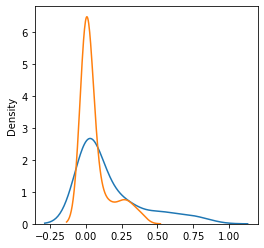

In [148]:
plt.figure(figsize=(4,4))
sns.distplot(v2, hist=False, kde=True)
sns.distplot(v1_norm[0], hist=False, kde=True)
plt.show()

### Define function

In [149]:
from scipy.special import rel_entr
from scipy.stats import ks_2samp
from sklearn import preprocessing

In [150]:
def eval_similarity(avail_window, target_window):

    l, r = 0, 0
    pairs = []

    while l<len(target_window) and r<len(avail_window):
        if target_window[3][l]==avail_window['word'][r]:
            pairs.append([(target_window[3][l], target_window[5][l]), (avail_window['word'][r], avail_window['pa.32'][r])])
            l+=1
            r+=1
        else:
            # print('mismatched pair', target_window[3][l], avail_window['word'][r], l, r)
            l+=1

    v1 = []
    v2 = []
    
    t1 = []
    t2 = []
    
    for pair in pairs:
        v1.append(pair[0][-1])
        v2.append(pair[1][-1])
        
        t1.append(pair[0][0])
        t2.append(pair[1][0])

    v1 = np.asarray(v1)
    v2 = np.asarray(v2)
    
    # print(t1)
    # print(t2)
    
    assert t1==t2
    assert v1.shape[0]==v2.shape[0]
    
    result = 1 - spatial.distance.cosine(v1, v2)

    v1_norm = preprocessing.normalize([v1])
    v2_norm = v2
    
    plt.figure(figsize=(4,4))
    sns.distplot(v2, hist=False, kde=True, label='ground_truth', color='green')
    sns.distplot(v1_norm[0], hist=False, kde=True, label='wavelet_pred', color='orange')
    plt.show()

    return result



### Multi-file analysis

In [151]:
annotations['filename'].unique()

array(['s02-1', 's03-1', 's04-1', 's10-1', 's11-1', 's14-1', 's16-1',
       's17-1', 's21-1', 's22-1', 's24-1', 's25-1', 's26-1', 's32-1',
       's33-1', 's35-1'], dtype=object)

#### S14

In [152]:
predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye_v1/s14-1.prom', header=None)
avail_window = annotations[annotations['filename']=="s14-1"].reset_index(drop=True)
# manually finding out the window indices
target_window = predictions[1:-1].reset_index(drop=True)

In [153]:
# predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye/s1401a.prom', header=None)
# avail_window = annotations[annotations['filename']=="s14-1"].reset_index(drop=True)
# # manually finding out the window indices
# target_window = predictions[5:72].reset_index(drop=True)

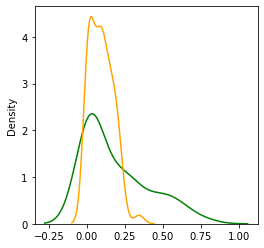

0.53939755098918

In [154]:
eval_similarity(avail_window, target_window)

#### S17

In [155]:
# predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye/s1701a.prom', header=None)
# avail_window = annotations[annotations['filename']=="s17-1"].reset_index(drop=True)
# target_window = predictions[606:656].reset_index(drop=True)

predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye_v1/s17-1.prom', header=None)
avail_window = annotations[annotations['filename']=="s17-1"].reset_index(drop=True)
target_window = predictions[1:-1].reset_index(drop=True)

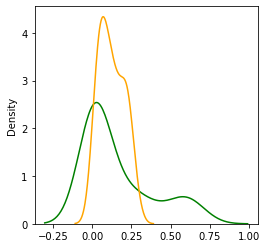

0.5422413115832743

In [156]:
eval_similarity(avail_window, target_window)

#### S21

In [157]:
# predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye/s2101b.prom', header=None)
# avail_window = annotations[annotations['filename']=="s21-1"].reset_index(drop=True)
# target_window = predictions[537:582].reset_index(drop=True)

predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye_v1/s21-1.prom', header=None)
avail_window = annotations[annotations['filename']=="s21-1"].reset_index(drop=True)
target_window = predictions[1:-1].reset_index(drop=True)

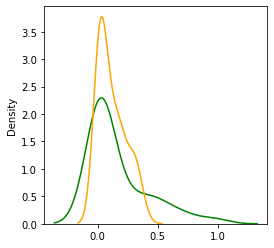

0.5021034293274435

In [158]:
eval_similarity(avail_window, target_window)

#### S22

In [159]:
# predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye/s2201a.prom', header=None)
# avail_window = annotations[annotations['filename']=="s22-1"].reset_index(drop=True)
# target_window = predictions[15:48].reset_index(drop=True)

predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye_v1/s22-1.prom', header=None)
avail_window = annotations[annotations['filename']=="s22-1"].reset_index(drop=True)
target_window = predictions[1:-1].reset_index(drop=True)

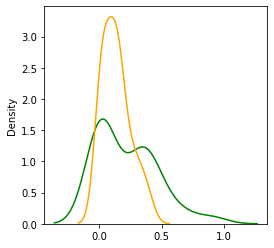

0.5649922680385793

In [160]:
eval_similarity(avail_window, target_window)

#### S25

In [161]:
# predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye/s2501a.prom', header=None)
# avail_window = annotations[annotations['filename']=="s25-1"].reset_index(drop=True)
# target_window = predictions[494:572].reset_index(drop=True)

predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye_v1/s25-1.prom', header=None)
avail_window = annotations[annotations['filename']=="s25-1"].reset_index(drop=True)
target_window = predictions[1:-1].reset_index(drop=True)

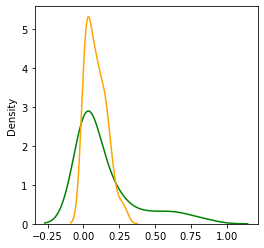

0.42704963872064283

In [162]:
eval_similarity(avail_window, target_window)

#### S26

In [163]:
# predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye/s2601a.prom', header=None)
# avail_window = annotations[annotations['filename']=="s26-1"].reset_index(drop=True)
# target_window = predictions[427:480].reset_index(drop=True)

predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye_v1/s26-1.prom', header=None)
avail_window = annotations[annotations['filename']=="s26-1"].reset_index(drop=True)
target_window = predictions[1:-1].reset_index(drop=True)

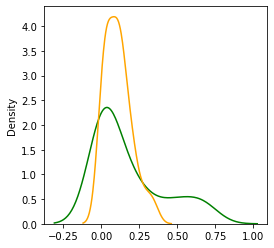

0.6256952818119855

In [164]:
eval_similarity(avail_window, target_window)

#### S32

In [165]:
# predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye/s3201a.prom', header=None)
# avail_window = annotations[annotations['filename']=="s32-1"].reset_index(drop=True)
# target_window = predictions[129:195].reset_index(drop=True)

predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye_v1/s32-1.prom', header=None)
avail_window = annotations[annotations['filename']=="s32-1"].reset_index(drop=True)
target_window = predictions[1:-1].reset_index(drop=True)



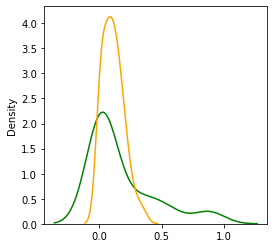

0.4592244336322495

In [166]:
eval_similarity(avail_window, target_window)

#### S33

In [167]:
# predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye/s3301a.prom', header=None)
# avail_window = annotations[annotations['filename']=="s33-1"].reset_index(drop=True)
# target_window = predictions[130:168].reset_index(drop=True)

In [128]:
# eval_similarity(avail_window, target_window)

#### S35

In [129]:
# predictions = pd.read_table('../emphases/baselines/prominence/test_outputs_buckeye/s3501a.prom', header=None)
# avail_window = annotations[annotations['filename']=="s35-1"].reset_index(drop=True)
# target_window = predictions[281:337].reset_index(drop=True)

In [130]:
# eval_similarity(avail_window, target_window)